In [8]:
import osmnx as ox
import geopy  # For geocoding
from geopy.geocoders import Nominatim
from geopy.distance import distance
from geopy.extra.rate_limiter import RateLimiter
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import networkx as nx
import pandas as pd

In [11]:
import random
# Define a function to generate random coordinates within a given radius of a central point
def generate_random_coordinates(center_lat, center_lon, radius):
    # Generate random distance and angle
    random_distance = random.random() * radius
    random_angle = random.random() * 360
    # Calculate random point coordinates
    return distance(kilometers=random_distance).destination((center_lat, center_lon), bearing=random_angle)

# Geocode the center of large residential areas in Bucharest
geolocator = Nominatim(user_agent="routing-system-big-data")
areas = ["Drumul Taberei, Bucharest", "Berceni, Bucharest", "Colentina, Bucharest", "Militari, Bucharest"]
radius = 2  # Radius in kilometers within which to generate house locations

# Get central coordinates of the areas
central_coordinates = {area: geolocator.geocode(area) for area in areas}

# Generate house locations
house_locations = []
num_locations_per_area = 5  # Number of locations to generate per area

for area, location in central_coordinates.items():
    if location:
        for _ in range(num_locations_per_area):
            random_coords = generate_random_coordinates(location.latitude, location.longitude, radius)
            house_locations.append((random_coords.latitude, random_coords.longitude))

# house_locations now contains the generated coordinates for the house locations
house_locations

[(44.41128899451666, 26.03490430973583),
 (44.41883739307562, 26.046563532084033),
 (44.42101565720484, 26.037462601081323),
 (44.42557454941454, 26.021781403466214),
 (44.42227463946682, 26.039253250983933),
 (44.394603397438594, 26.114898179629325),
 (44.37523009667945, 26.133015670839495),
 (44.38645999206103, 26.125427365548536),
 (44.40024552607466, 26.108489564836336),
 (44.37791766783666, 26.11280473407687),
 (44.482456616098254, 26.15799241434252),
 (44.464077583104284, 26.159931426594145),
 (44.45791145657366, 26.152793201337477),
 (44.465165739111214, 26.147684972392984),
 (44.470159199672615, 26.137070287412275),
 (44.432672718764245, 26.02026376258904),
 (44.43966794471372, 25.995854414170445),
 (44.43760912607477, 26.01369242441525),
 (44.438372947462284, 26.02112429345889),
 (44.426537373372994, 26.0026377934466)]

In [12]:

# Constants
CENTER_LOCATION = (44.413162, 26.163739)  # Replace with actual depot coordinates
DIST = 3000  # Adjust as needed
NUM_VEHICLES = 4  # Adjust as needed


depot_location = CENTER_LOCATION  # Replace with actual depot coordinates if different

# Function to geocode address
def geocode_address(address, geolocator):
    location = geolocator.geocode(address)
    return (location.latitude, location.longitude)

# Function to calculate distance matrix
def calculate_distance_matrix(locations, G):
    distance_matrix = []
    for loc1 in locations:
        row = []
        for loc2 in locations:
            node1 = ox.nearest_nodes(G, *loc1[::-1])
            node2 = ox.nearest_nodes(G, *loc2[::-1])
            length = nx.shortest_path_length(G, node1, node2, weight='length')
            row.append(length)
        distance_matrix.append(row)
    return distance_matrix


In [4]:

# Get the road network graph
G = ox.graph_from_point(CENTER_LOCATION, dist=DIST, network_type='drive')
G = ox.utils_graph.get_largest_component(G, strongly=True)

# Geocode addresses if necessary
if house_locations:  # Check if house_locations is not empty
    if isinstance(house_locations[0], str):  # Check if the first element is a string
        geolocator = Nominatim(user_agent="your_user_agent")  # Provide your user agent
        geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
        # Assuming you want to geocode the addresses and save the coordinates
        house_locations = [(geocode(location).latitude, geocode(location).longitude) 
                           for location in house_locations]
else:
    # Handle the case where house_locations is empty
    print("The list 'house_locations' is empty. Please provide valid addresses or coordinates.")
# Add depot to the list of locations
all_locations = house_locations + [depot_location]

# Calculate the distance matrix
distance_matrix = calculate_distance_matrix(all_locations, G)

# Create the routing model
manager = pywrapcp.RoutingIndexManager(len(distance_matrix), NUM_VEHICLES, 0)
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return distance_matrix[from_node][to_node]

IndexError: list index out of range

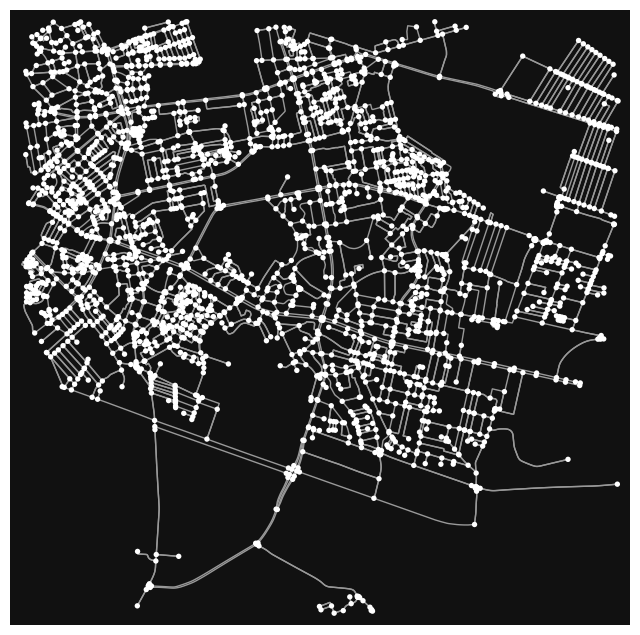

In [4]:

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Set the cost of travel
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    30000,  # vehicle maximum travel distance, adjust as needed
    True,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

# Set the starting and ending nodes (all vehicles start and end at depot)
depot_index = len(all_locations) - 1
for vehicle_id in range(NUM_VEHICLES):
    routing.AddVariableMinimizedByFinalizer(distance_dimension.CumulVar(routing.Start(vehicle_id)))
    routing.AddVariableMinimizedByFinalizer(distance_dimension.CumulVar(routing.End(vehicle_id)))
    routing.SetStart(vehicle_id, manager.NodeToIndex(depot_index))
    routing.SetEnd(vehicle_id, manager.NodeToIndex(depot_index))

# Solve the problem.
solution = routing.SolveWithParameters(pywrapcp.DefaultRoutingSearchParameters())

# Print solution on console.
if solution:
    print("Routes:")
    total_distance = 0
    for vehicle_id in range(NUM_VEHICLES):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} ->'.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += ' {}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
    print('Total Distance of all routes: {}m'.format(total_distance))
else:
    print("No solution found!")

6529858706

[10686527758, 10686527759, 10686527760, 10686527761, 10686527762]